In [2]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

In [3]:
gdf_amg = aqiGDL.gdf_from_db('municipios_amg','areas')
gdf_amg = ox.project_gdf(gdf_amg,to_crs='EPSG:32613')
gdf_amg.head(2)

,CVE_ENT,CVE_MUN,NOM_MUN,OID,geometry
0,14,039,Guadalajara,631,"MULTIPOLYGON (((675777.419 2295506.182, 675934..."
1,14,044,Ixtlahuacán de los Membrillos,636,"MULTIPOLYGON (((686951.828 2265175.682, 687013..."


In [4]:
gdf_est = aqiGDL.gdf_from_db('estaciones_gdl','estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')
gdf_est.head(2)

,Name,x,y,geometry
0,10. Colon,-103.400806,20.606105,POINT (666650.899 2279373.835)
1,11. UVM,-103.406642,20.608323,POINT (666040.129 2279613.376)


In [5]:
gdf_edge = aqiGDL.gdf_from_db('guadalajara_edges','networks')
gdf_edge = ox.project_gdf(gdf_edge,to_crs='EPSG:32613')
gdf_edge.head(2)

,osmid,highway,oneway,length,geometry,name,lanes,bridge,access,junction,maxspeed,ref,service,tunnel,width,area,u,v,key
0,149698947,secondary,True,51.862,"LINESTRING (678752.310 2282699.577, 678738.504...",Avenida Patria,2,None,None,None,None,None,None,None,None,None,1619378249,4746157497,0
1,148880014,residential,False,202.824,"LINESTRING (678752.310 2282699.577, 678614.302...",Calle Anacleto Caminos,None,None,None,None,None,None,None,None,None,None,1619378249,1619378323,0


In [6]:
df = pd.read_csv('../data/external/Google-emisiones-transporte.csv')
df.Ciudad.apply(str)
df.head(2)

,Ciudad,Modo,Porcentaje-uso,Eficiencia,Emision
0,Guadalajara,Automovil,85.60,9.1,0.002
1,Guadalajara,Autobus,2.04,5.2,0.003


In [7]:
gdf_edge['length'] = gdf_edge.geometry.length
gdf_edge.head(2)

,osmid,highway,oneway,length,geometry,name,lanes,bridge,access,junction,maxspeed,ref,service,tunnel,width,area,u,v,key
0,149698947,secondary,True,51.659478,"LINESTRING (678752.310 2282699.577, 678738.504...",Avenida Patria,2,None,None,None,None,None,None,None,None,None,1619378249,4746157497,0
1,148880014,residential,False,202.772328,"LINESTRING (678752.310 2282699.577, 678614.302...",Calle Anacleto Caminos,None,None,None,None,None,None,None,None,None,None,1619378249,1619378323,0


In [8]:
gdf_est['municipio'] = gpd.sjoin(gdf_est,gdf_amg)['NOM_MUN']
gdf_est.head(2)

,Name,x,y,geometry,municipio
0,10. Colon,-103.400806,20.606105,POINT (666650.899 2279373.835),San Pedro Tlaquepaque
1,11. UVM,-103.406642,20.608323,POINT (666040.129 2279613.376),San Pedro Tlaquepaque


In [9]:
buffer_dist = 1000
buffer = gpd.GeoDataFrame({'geometry':gdf_est.buffer(buffer_dist),'Name':gdf_est['Name'], 'municipio':gdf_est['municipio']},geometry='geometry',crs=gdf_est.crs)

In [10]:
for i in range(len(buffer)):
    clip = gpd.clip(gdf_edge, buffer.iloc[i].geometry)
    clip['length'] = clip.geometry.length
    
    buffer.loc[i,'sum_length'] = clip.length.sum()

In [11]:
buffer.sort_values(by='sum_length', ascending=False, inplace=True)
buffer['municipio'] = buffer['municipio'].astype(str) 
buffer.head(5)

,geometry,Name,municipio,sum_length
36,"POLYGON ((675370.434 2292195.527, 675365.618 2...",43. Rancho Nuevo,Guadalajara,147967.523795
25,"POLYGON ((668878.411 2294257.154, 668873.596 2...",33. Pino Suarez,Zapopan,147768.624180
22,"POLYGON ((666688.733 2293522.165, 666683.918 2...",30. Tuzania,Zapopan,146101.390612
9,"POLYGON ((663151.950 2284052.529, 663147.135 2...",19. Tepeyac,Zapopan,142943.651057
33,"POLYGON ((673375.385 2292984.179, 673370.570 2...",40. Saltillo,Zapopan,142902.563707


In [12]:
emisiones = df[df['Ciudad']=='Guadalajara']
emisiones

,Ciudad,Modo,Porcentaje-uso,Eficiencia,Emision
0,Guadalajara,Automovil,85.60,9.1,0.002
1,Guadalajara,Autobus,2.04,5.2,0.003
2,Guadalajara,Motocicleta,6.15,31.4,0.002


In [13]:
for c in df.Ciudad:
    
    buffer_c = buffer.loc[buffer.municipio==c]
    
    for est in buffer_c.Name:
    
        distancia = float(buffer_c.loc[buffer_c.Name==est]['sum_length']/1000)
        
        #print ()
        
        co2_auto = (distancia*float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Porcentaje-uso']/100)/
                    float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Eficiencia'])*
                   float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Emision']))
        
        co2_bus = (distancia*float(df.loc[(df.Ciudad==c)&(df.Modo=='Autobus'),'Porcentaje-uso']/100)/
                    float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Eficiencia'])*
                   float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Emision']))
        
        co2_moto = (distancia*float(df.loc[(df.Ciudad==c)&(df.Modo=='Motocicleta'),'Porcentaje-uso']/100)/
                    float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Eficiencia'])*
                   float(df.loc[(df.Ciudad==c)&(df.Modo=='Automovil'),'Emision']))
        
        buffer.loc[(buffer.Name==est), 'tonCO₂eq'] = (co2_auto + co2_bus + co2_moto) * 254

In [14]:
buffer.head(1)

,geometry,Name,municipio,sum_length,tonCO₂eq
36,"POLYGON ((675370.434 2292195.527, 675365.618 2...",43. Rancho Nuevo,Guadalajara,147967.523795,7.747209


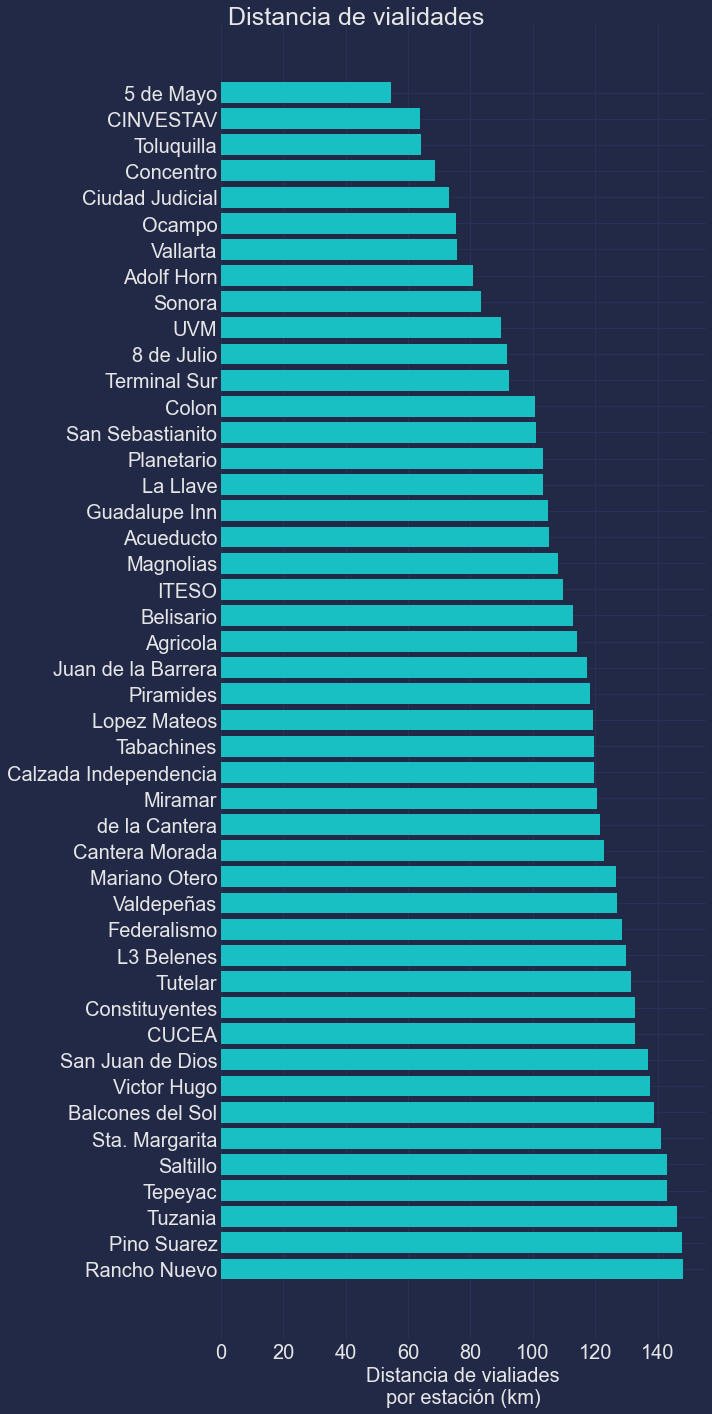

In [15]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(10,20))
ax.barh(buffer['Name'].apply(lambda x: x.split(' ',maxsplit=1)[1]), buffer['sum_length']/1000)
ax.set_xlabel('Distancia de vialiades\npor estación (km)',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Distancia de vialidades',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/emisiones_transporte/DistanciaVialidades.png',dpi=300)

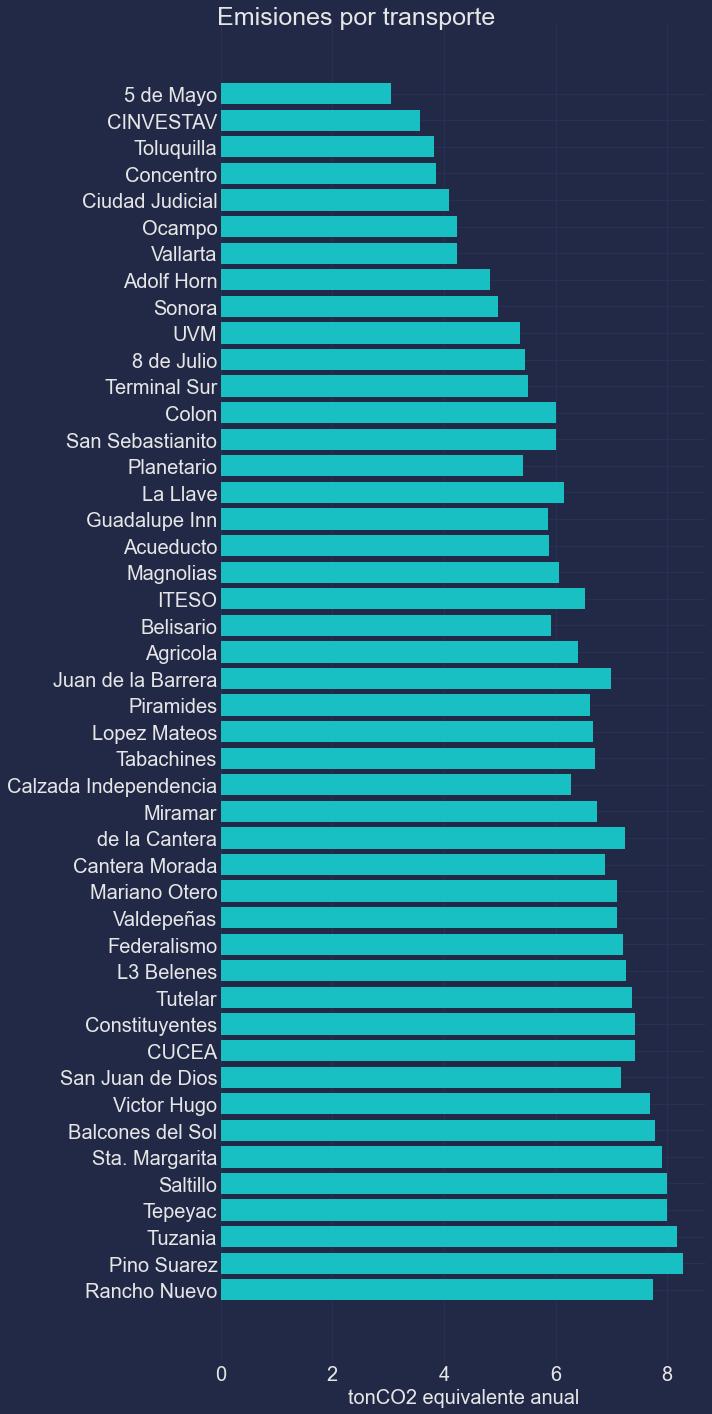

In [23]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
fig, ax = plt.subplots(1,1,figsize=(10,20))
ax.barh(buffer['Name'].apply(lambda x: x.split(' ',maxsplit=1)[1]), buffer['tonCO₂eq'])
ax.set_xlabel('tonCO2 equivalente anual',fontsize=20)
ax.tick_params(labelsize=20)
fig.suptitle('Emisiones por transporte',fontsize=25)
fig.tight_layout()
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades.png',dpi=300)
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades.svg',dpi=300)

In [17]:
dist = 1000
data = []
areas = {}
edges_data = []
for i in range(len(gdf_est)):
    x = gdf_est.at[i,'x']
    y = gdf_est.at[i,'y']
    est = gdf_est.at[i,'Name']
    point = (y, x)
    G = ox.graph_from_point(point,dist=dist)
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges['Estacion'] = est
    edges = ox.project_gdf(edges)
    edges_data.append(edges)
    G = None
    edges = None

In [18]:
edges = pd.concat(edges_data, ignore_index=True)
edges = ox.project_gdf(edges,to_crs='EPSG:32613')
edges

,osmid,oneway,lanes,highway,maxspeed,length,geometry,name,access,junction,bridge,service,tunnel,u,v,key,Estacion,width,ref,area
0,495077540,True,3,primary_link,50,54.526,"LINESTRING (666578.750 2279496.577, 666568.550...",NaN,NaN,NaN,NaN,NaN,NaN,1357351174,1643793186,0,10. Colon,NaN,NaN,NaN
1,"[618093410, 618093411]",False,NaN,footway,NaN,12.735,"LINESTRING (666578.750 2279496.577, 666580.949...",NaN,NaN,NaN,NaN,NaN,NaN,1357351174,5842487317,0,10. Colon,NaN,NaN,NaN
2,"[618093411, 618077078, 618088142, 618077079]",False,NaN,footway,NaN,97.194,"LINESTRING (666578.750 2279496.577, 666577.350...",NaN,NaN,NaN,NaN,NaN,NaN,1357351174,5842357468,0,10. Colon,NaN,NaN,NaN
3,257137169,False,4,secondary,NaN,64.679,"LINESTRING (666589.588 2278773.995, 666639.377...",Calle Comonfort,NaN,NaN,NaN,NaN,NaN,1430324041,1708793237,0,10. Colon,NaN,NaN,NaN
4,257137169,False,4,secondary,NaN,86.346,"LINESTRING (666589.588 2278773.995, 666527.209...",Calle Comonfort,NaN,NaN,NaN,NaN,NaN,1430324041,1479622383,0,10. Colon,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87948,838819000,False,NaN,service,NaN,30.977,"LINESTRING (668125.619 2277796.784, 668101.848...",NaN,NaN,NaN,NaN,NaN,NaN,7827785144,4682653635,0,9. de la Cantera,NaN,NaN,NaN
87949,738370659,True,3,trunk,80,101.885,"LINESTRING (668201.678 2277726.560, 668139.726...",Anillo Periférico Sur Manuel Gómez Morín,NaN,NaN,NaN,NaN,NaN,7827785145,6542667373,0,9. de la Cantera,NaN,NaN,NaN
87950,"[838819001, 838819002, 831442940, 831442941, 8...",False,NaN,"[footway, steps]",NaN,63.803,"LINESTRING (668201.678 2277726.560, 668209.041...",NaN,NaN,NaN,yes,NaN,NaN,7827785145,7827785146,0,9. de la Cantera,NaN,NaN,NaN
87951,821961725,True,3,trunk,80,55.551,"LINESTRING (668187.467 2277717.263, 668221.469...",Anillo Periférico Sur Manuel Gómez Morín,NaN,NaN,NaN,NaN,NaN,7827785146,1790252090,0,9. de la Cantera,NaN,NaN,NaN


In [19]:
gdf_est_ = gpd.sjoin(gdf_est,buffer.drop(columns=['Name']))
gdf_est_ = gdf_est_.drop_duplicates(subset = 'Name', keep = 'first')
gdf_est_.head(1)

,Name,x,y,geometry,municipio_left,index_right,municipio_right,sum_length,tonCO₂eq
0,10. Colon,-103.400806,20.606105,POINT (666650.899 2279373.835),San Pedro Tlaquepaque,1,San Pedro Tlaquepaque,89913.773403,5.356878


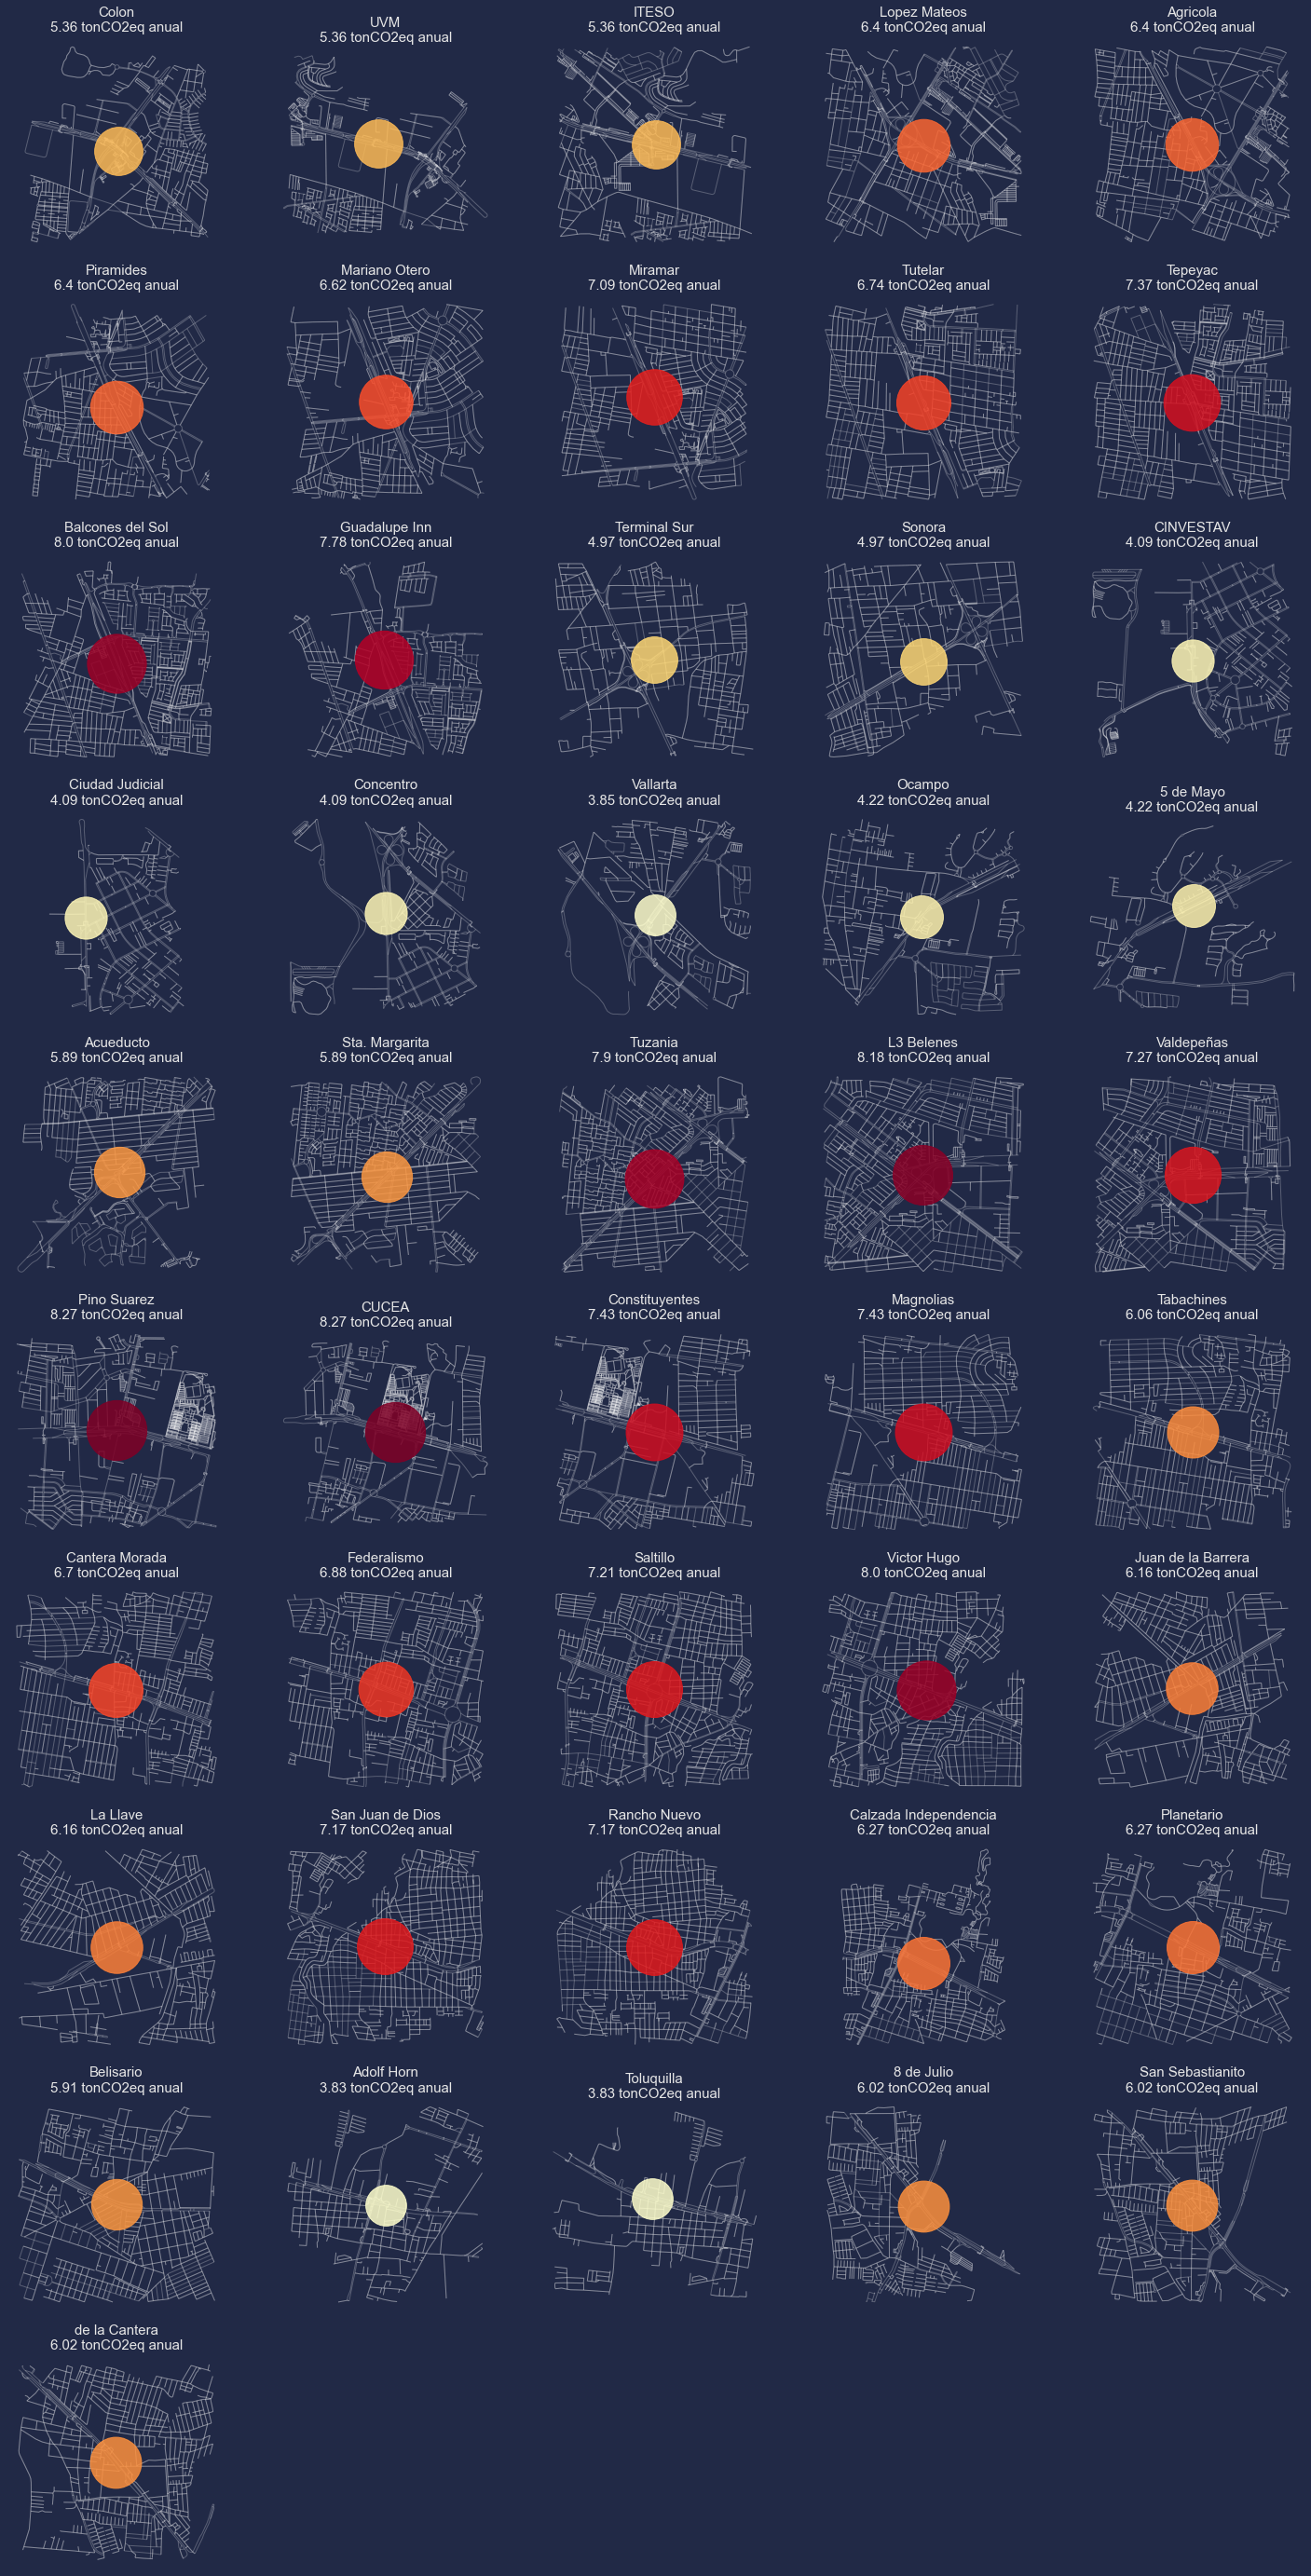

In [22]:
fig, axes = plt.subplots(10,5,figsize = (25,50))
for i, ax in zip(gdf_est_.index.tolist(), axes.flatten()):
    est = gdf_est_.at[i,'Name']
    edges[edges['Estacion'] == est].plot(ax=ax, color='w', zorder=1, alpha=0.25, linewidth=1)
    gdf_est_[gdf_est_['Name'] == est].plot(ax=ax, column ='tonCO₂eq', cmap='YlOrRd', markersize=gdf_est_[gdf_est_['Name'] == est]['tonCO₂eq']*500, alpha=0.85, zorder=3, vmin=gdf_est_['tonCO₂eq'].min(), vmax=gdf_est_['tonCO₂eq'].max())
    ax.set_title('{}\n{:,} tonCO2eq anual'.format(est.split(' ',maxsplit=1)[1], round(gdf_est_[gdf_est_['Name'] == est]['tonCO₂eq'].values[0],2)), fontsize=15)
    ax.axis('off')
for ax in axes.flatten()[46:]:
    ax.set_visible(False)
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades_Mapa.png',dpi=300)
plt.savefig('../output/figures/emisiones_transporte/EmisionesVialidades_Mapa.svg',dpi=300)